# Tutorial 01
In this tutorial we'll see how the basic functions of module MDZip can be used to compress a small Molecular Dynamics (MD) trajectory of insulin.

First the required modules are loaded:

In [1]:
from mdzip.mdzip_core import *

# For visualization purpose only:
import mdtraj as md
import nglview as nv
from matplotlib import pyplot as plt
import numpy as np

Seting a seed is optional, but this will help to keep consistancy.
Afterwards we'll define the locations of the trajectory file and the topology file.

In [2]:
set_seed() #Optional but recommended

In [3]:
trajectory = '/blue/alberto.perezant/t.desilva/new_MolZip/MolZip/alanine-dipeptide.nc'
topology = '/blue/alberto.perezant/t.desilva/new_MolZip/MolZip/alanine-dipeptide.prmtop'

Before compressing let's load and view the MD trajectory with MDTraj and NGLview.

In [4]:
traj_ = md.load(trajectory, top=topology)
view = nv.show_mdtraj(traj_)
view

NGLWidget(max_frame=99999)

Now lets start the training process. Here, we feed all the frames of the trajectory to our autoencoders, so that it learns the latent for all the sampled conformations.<br>
Training involves reading the trajectories, shuffle and scaling. When reading the large trajectories set <code>memmap=True</code> to use memmory maps (low RAM).

In [5]:
train(
    traj= trajectory, # trajectory file path
    top=topology, # topology file path
    stride=1, # stride to use when reading trajectory
    fname='ap', # prefix to identify new files
    epochs=10,
    lat=10, # bottleneck
    batchSize=128,
    model_type='AE',
    memmap=False # Do not use memmory maps when reading trajectory
)


Trajectory stats : #_Frames = 100000	#_Atoms = 22
______________________________________________________________________ 

Start reading coordinates from trajectory to train model...
[100000 frames with stride 1]


Loading trajectory: 100.00% |████████████████████|
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


______________________________________________________________________



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type | Params | Mode 
-----------------------------------------
0 | model   | AE   | 3.5 M  | train
1 | loss_fn | Loss | 0      | train
-----------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.130    Total estimated model params size (MB)
35        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Autoencoder training complete
______________________________________________________________________





Now above process creates new directory "ap_compressed" (<code>\<fname\>_compressed</code>). We can see the scaler (<code>ap_scaler.pkl</code>), loss (<code>ap_losses.dat</code>), checkpoint files (<code>ap_checkpoint.ckpt</code> & <code>ap_checkpoint.pt</code>) and trained model weights (<code>ap_model_weights.pt.xz</code>).

In [6]:
ls ap_compressed/

ap_checkpoint.ckpt  ap_losses.dat           ap_scaler.pkl
ap_checkpoint.pt    ap_model_weights.pt.xz


Now we can plot the training curve using the <code>ap_losses.dat</code>

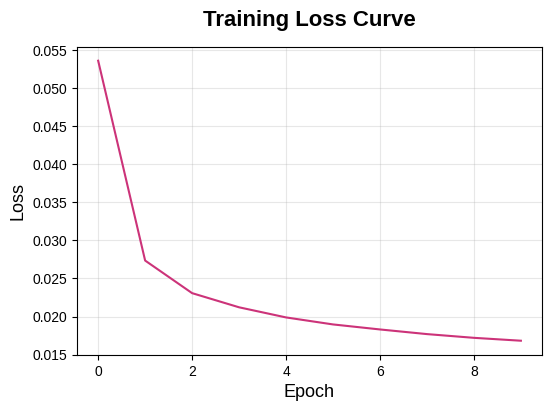

In [7]:
plt.figure(figsize=(6, 4))
plt.plot(
    np.loadtxt('ap_compressed/ap_losses.dat', usecols=1),
    color='#CC3379',
    lw=1.5,
    label='trainig loss'
)

plt.title('Training Loss Curve', fontsize=16, weight='bold', pad=15)
plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.grid(alpha=0.3)

# plt.tight_layout()
plt.style.use('seaborn-v0_8-whitegrid')
plt.show()

In [8]:
cont_train(
    traj='/blue/alberto.perezant/t.desilva/new_MolZip/MolZip/alanine-dipeptide.nc',
    top='/blue/alberto.perezant/t.desilva/new_MolZip/MolZip/alanine-dipeptide.prmtop',
    model='ap_compressed/ap_model_weights.pt.xz',
    checkpoint='ap_compressed/ap_checkpoint.pt',
    epochs=40,
    model_type='AE'
          )


Trajectory stats : #_Frames = 100000	#_Atoms = 22
______________________________________________________________________ 

Start reading coordinates from trajectory to train model...
[100000 frames with stride 1]


Loading trajectory: 100.00% |████████████████████|
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at /blue/alberto.perezant/t.desilva/MDZip/example/ap_compressed/ap_checkpoint.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type | Params | Mode 
-----------------------------------------
0 | model   | AE   | 3.5 M  | train
1 | loss_fn | Loss | 0      | train
-----------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.130    Total estimated model params size (MB)
35        Modules in train mode
0         Modules in eval mode
Restored all states from the checkpoint at /blue/alberto.perezant/t.desilva/MDZip/example/ap_compressed/ap_checkpoint.ckpt
SLURM auto-requeueing enabled. Setting signal handlers.


______________________________________________________________________



Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Autoencoder training complete
______________________________________________________________________





Now let's visualize the training curve after cntinuing training for another 30 epochs. The training is continued from the last step.

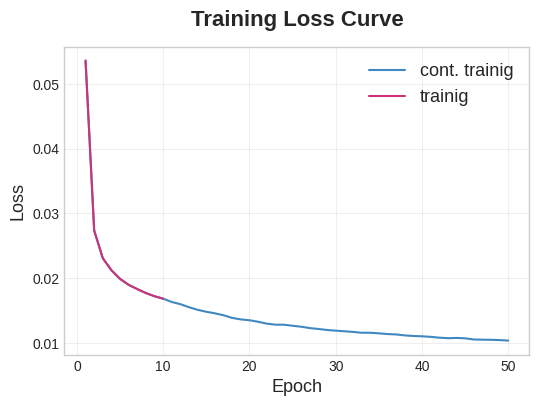

In [16]:
plt.figure(figsize=(6, 4))
y = np.loadtxt('ap_compressed/ap_losses.dat', usecols=1)
x = np.arange(1, y.shape[0]+1)
plt.plot(
    x,y,
    color='#4088BF',
    lw=1.5,
    label='cont. trainig'
)

plt.plot(
    x[:10], y[:10],
    color='#CC3379',
    lw=1.5,
    label='trainig'
)

plt.title('Training Loss Curve', fontsize=16, weight='bold', pad=15)
plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.grid(alpha=0.3)
plt.legend(fontsize=13)

# plt.tight_layout()
plt.style.use('seaborn-v0_8-whitegrid')
plt.show()

Now we can finally compress the trajectory using the trained model parameters and the trajectory and topology files. Following snippet will compress the trajectory and create <code>ap_compressed_lat.pt.xz</code>.

In [10]:
compress(
    traj='/blue/alberto.perezant/t.desilva/new_MolZip/MolZip/alanine-dipeptide.nc',
    top='/blue/alberto.perezant/t.desilva/new_MolZip/MolZip/alanine-dipeptide.prmtop',
    model='ap_compressed/ap_model_weights.pt.xz',
    model_type='AE',
    fname='ap',
    memmap=False
)

______________________________________________________________________


Trajectory stats : #_Frames = 100000	#_Atoms = 22
______________________________________________________________________ 

Start reading coordinates from trajectory to train model...
[100000 frames with stride 1]


Loading trajectory: 100.00% |████████████████████|
Compressing : 100%|██████████| 100001/100001 [00:55<00:00, 1813.01it/s]


______________________________________________________________________

Original Size [MB]   :         31.601
Compressed Lat [MB]  :          0.930
Compression %        :         97.057
Saved: ap_compressed/ap_compressed_lat.pt.xz
---


In [11]:
!ls ap_compressed/

ap_checkpoint.ckpt  ap_compressed_lat.pt.xz  ap_model_weights.pt.xz
ap_checkpoint.pt    ap_losses.dat	     ap_scaler.pkl


Now to decompress the above compressed file we require <code>ap_compressed_lat.pt.xz</code>, topology file, model parameters and the scaler. Here, we can input the output file name. Makesure to add the complete path followed by the desired file name and extension. In this example snippet we have use <code>out='/orange/alberto.perezant/t.desilva/test.nc'</code>.

In [12]:
decompress(
    top='/blue/alberto.perezant/t.desilva/new_MolZip/MolZip/alanine-dipeptide.prmtop',
    model='ap_compressed/ap_model_weights.pt.xz',
    model_type='AE',
    compressed='ap_compressed/ap_compressed_lat.pt.xz',
    scaler='ap_compressed/ap_scaler.pkl',
    out='/orange/alberto.perezant/t.desilva/test.nc'
)

Decompressing : 100%|██████████| 100001/100001 [01:05<00:00, 1525.63it/s]


Decompression complete



Now we can visualize the new trajectory and compare.

In [17]:
traj_recon = md.load('/orange/alberto.perezant/t.desilva/test.nc', top=topology)
view = nv.show_mdtraj(traj_recon)
view

NGLWidget(max_frame=100000)

### NOTE:
The checkpoint files generated during the training process might be large in size compared. If the model is stable and it does not need further training, you can remove the checkpoints once traing is completed.